In [1]:
pip install tensorflow keras opencv-python numpy lxml

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import cv2
import xml.etree.ElementTree as ET
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Input
from tensorflow.keras.models import Model


In [15]:
import os
import xml.etree.ElementTree as ET

# Define the directory where the XML files and images are stored
image_dir = '/Users/cornflex/Desktop/Project/T5/T5-CapstoneProject/Model/OCR Model/Dataset/License-Characters-by-2-27classes/train'  # Update this with your path
xml_dir = '/Users/cornflex/Desktop/Project/T5/T5-CapstoneProject/Model/OCR Model/Dataset/License-Characters-by-2-27classes/train'    # Update this with your path

# Parse the XML and extract filename, labels, and bounding boxes
def parse_xml(xml_file):
    try:
        tree = ET.parse(xml_file)
        root = tree.getroot()

        # Extract the filename from the XML
        filename = root.find('filename').text
        labels = []
        bboxes = []

        # Extract each label and corresponding bounding box
        for obj in root.findall('object'):
            label = obj.find('name').text
            labels.append(label)

            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            bboxes.append([xmin, ymin, xmax, ymax])

        return filename, labels, bboxes

    except ET.ParseError as e:
        print(f"Error parsing XML file {xml_file}: {e}")
        return None, None, None

# Check if the labels contain exactly three alphabetic characters
def has_three_alphabets(labels):
    alphabet_count = sum([1 for label in labels if label.isalpha()])
    return alphabet_count == 3

# Loop through the XML files and collect images with valid labels and bounding boxes
image_labels = []
for xml_filename in os.listdir(xml_dir):
    if xml_filename.endswith('.xml'):
        xml_file_path = os.path.join(xml_dir, xml_filename)

        # Parse XML and extract filename, labels, and bounding boxes
        image_filename, labels, bboxes = parse_xml(xml_file_path)

        if image_filename and labels and bboxes:
            # Only process images with exactly three alphabetic characters
            if has_three_alphabets(labels):
                image_path = os.path.join(image_dir, image_filename)

                # Ensure the image file exists (regardless of the image format)
                if os.path.exists(image_path):
                    image_labels.append((image_path, bboxes, labels))
                else:
                    # Try with different extensions if the default one doesn't exist
                    possible_extensions = ['.jpeg', '.png', '.jpg']
                    for ext in possible_extensions:
                        alt_image_path = os.path.join(image_dir, image_filename.replace('.jpeg', ext))
                        if os.path.exists(alt_image_path):
                            image_labels.append((alt_image_path, bboxes, labels))
                            break

# Formatting labels for OCR use
def format_labels_for_ocr(image_labels):
    formatted_labels = []
    for image_path, bboxes, labels in image_labels:
        text_label = ''.join(labels)  # Concatenate the labels into one string
        formatted_labels.append((image_path, bboxes, text_label))
    return formatted_labels

# Get the formatted image paths, bounding boxes, and labels
formatted_image_labels = format_labels_for_ocr(image_labels)


In [17]:
import cv2
import numpy as np

def load_and_preprocess_data(data_list, target_size=(128, 128)):
    images = []
    bboxes = []
    labels = []

    for data in data_list:
        image_path, bounding_boxes, label = data
        
        # Load the image
        image = cv2.imread(image_path)
        
        # Resize the image to target size
        image_resized = cv2.resize(image, target_size)
        
        # Normalize the image
        image_resized = image_resized.astype('float32') / 255.0
        
        # Add to our list
        images.append(image_resized)
        bboxes.append(bounding_boxes)  # Keep the bounding boxes as they are for now
        labels.append(label)  # Append the label as it is
        
    return np.array(images), bboxes, labels

images, bboxes, labels = load_and_preprocess_data(formatted_image_labels)


In [24]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Flatten labels into a list of individual characters
def encode_labels(labels):
    all_characters = ''.join(labels)  # Concatenate all characters into a single string
    unique_chars = sorted(set(all_characters))  # Unique characters in sorted order

    # Initialize the label encoder
    label_encoder = LabelEncoder()
    label_encoder.fit(unique_chars)  # Fit on unique characters

    encoded_labels = []
    for label in labels:
        # Encode each character into its corresponding integer and then one-hot encode
        encoded = label_encoder.transform(list(label))
        one_hot_encoded = to_categorical(encoded, num_classes=len(unique_chars))
        encoded_labels.append(one_hot_encoded)
    
    return encoded_labels, label_encoder, len(unique_chars)

# Example usage:
encoded_labels, label_encoder, num_classes = encode_labels(labels)

In [63]:
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import Dropout, Reshape, LSTM, Bidirectional, TimeDistributed, Dense, Conv2D, MaxPooling2D, Flatten, Input
from tensorflow.keras.models import Model

# Updated OCR Model with L2 Regularization
def build_ocr_model_with_regularization(input_shape=(128, 128, 3), num_classes=36, max_text_length=10, dropout_rate=0.5):
    # Define the input for the images
    inputs = Input(shape=input_shape, name='image_input')

    # Convolutional layers for feature extraction
    x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l1(0.01))(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(48, (3, 3), activation='relu', padding='same', kernel_regularizer=l1(0.01))(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(dropout_rate)(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l1(0.01))(x)
    x = MaxPooling2D((2, 2))(x)

    # Flatten the output of the convolutional layers
    x = Flatten()(x)
    x = Dense(max_text_length * 128, activation='relu', kernel_regularizer=l1(0.01))(x)  # Adjusted number of units
    # x = Dropout(dropout_rate)(x)

    # Reshape to (max_text_length, 128)
    x = Reshape((max_text_length, 128))(x)

    # Bidirectional LSTM for sequence processing
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    # x = Dropout(dropout_rate)(x)  # Dropout between LSTM layers
    x = TimeDistributed(Dense(num_classes, activation='softmax'))(x)

    # Build the model
    model = Model(inputs=inputs, outputs=x)
    return model


In [64]:
# Example parameters
input_shape = (128, 128, 3)
max_text_length = 10  # Set this to the maximum number of characters expected in the labels

# Build the model
ocr_model = build_ocr_model_with_regularization(input_shape=input_shape, num_classes=num_classes, max_text_length=max_text_length, dropout_rate=0.5)

# Check the model summary
ocr_model.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 64, 64, 48)     │        13,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 32, 32, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32, 32, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 32, 32, 64)     │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1280)           │    20,972,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_8 (Reshape)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 10, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 10, 27)         │         3,483 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,117,579 (80.56 MB)

 Trainable params: 21,117,579 (80.56 MB)

 Non-trainable params: 0 (0.00 B)

In [65]:
# Compile the model
def compile_ocr_model(model):
    model.compile(optimizer='adam', 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])

# Compile the OCR model
compile_ocr_model(ocr_model)


In [66]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Padding the encoded labels to a fixed length (max_text_length)
def pad_encoded_labels(encoded_labels, max_text_length):
    padded_labels = []
    
    for label in encoded_labels:
        # Pad each label's one-hot encoded characters with zero vectors to match the max_text_length
        padding_needed = max_text_length - label.shape[0]
        
        if padding_needed > 0:
            # Create padding of shape (padding_needed, num_classes)
            padding = np.zeros((padding_needed, label.shape[1]))
            padded_label = np.vstack([label, padding])
        else:
            # If label is already of max length or longer, truncate it
            padded_label = label[:max_text_length]
        
        padded_labels.append(padded_label)
    
    return np.array(padded_labels)

# Pad the encoded labels
padded_encoded_labels = pad_encoded_labels(encoded_labels, max_text_length)

In [67]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Example training parameters
batch_size = 32
epochs = 200
validation_split = 0.2

# Set early stopping to monitor validation loss and stop when it doesn't improve
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

images_train, images_val, labels_train, labels_val = train_test_split(
    images, padded_encoded_labels, test_size=validation_split, random_state=42
)

# Train the model without data augmentation, using plain images and labels
history = ocr_model.fit(
    images_train,              # Training images
    labels_train,              # Training labels (padded_encoded_labels)
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(images_val, labels_val),  # Validation data
    callbacks=[early_stopping]
)

Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 313ms/step - accuracy: 0.0776 - loss: 1420.6892 - val_accuracy: 0.1110 - val_loss: 327.2728
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 265ms/step - accuracy: 0.0961 - loss: 267.7942 - val_accuracy: 0.1030 - val_loss: 163.8763
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 263ms/step - accuracy: 0.1036 - loss: 129.5506 - val_accuracy: 0.1030 - val_loss: 71.9204
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 273ms/step - accuracy: 0.1068 - loss: 63.5709 - val_accuracy: 0.1110 - val_loss: 44.8350
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 250ms/step - accuracy: 0.1016 - loss: 40.5282 - val_accuracy: 0.1130 - val_loss: 33.6958
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 302ms/step - accuracy: 0.1107 - loss: 32.2380 - val_accuracy: 0.1150 - val_loss: 29.7701
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 284ms/step - accuracy: 0.0958 - loss: 29.0209 - val_accuracy: 0.1150 - val_loss: 27.6413
Epoch 8/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 268ms/step - accuracy: 0.1085 - los

KeyboardInterrupt: 

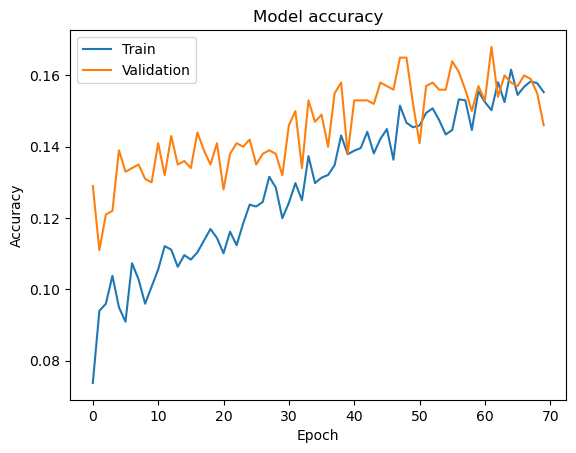

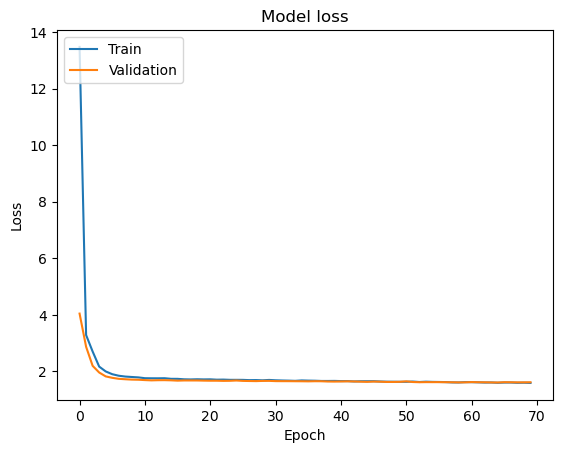

In [68]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss
def plot_training_history(history):
    # Accuracy plot
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Loss plot
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Plot the training history
plot_training_history(history)


In [24]:
pip install tensorflow==2.9

ERROR: Could not find a version that satisfies the requirement tensorflow==2.9 (from versions: 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0)
ERROR: No matching distribution found for tensorflow==2.9
Note: you may need to restart the kernel to use updated packages.


In [21]:
pip install keras-ocr

Note: you may need to restart the kernel to use updated packages.


In [22]:
pip install keras==2.9.0

  Using cached keras-2.9.0-py2.py3-none-any.whl.metadata (1.3 kB)
Using cached keras-2.9.0-py2.py3-none-any.whl (1.6 MB)
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.17.0 requires keras>=3.2.0, but you have keras 2.9.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [23]:
import keras_ocr
import cv2
import numpy as np

AttributeError: module 'inspect' has no attribute 'ArgSpec'

In [8]:
def preprocess_data(image_paths, bboxes, labels):
    training_data = []

    for image_path, bbox_list, label_list in zip(image_paths, bboxes, labels):
        # Read the image
        image = cv2.imread(image_path)
        
        # For each label and its corresponding bounding box, append to the training data
        for bbox, label in zip(bbox_list, label_list):
            # Bounding boxes need to be in the format expected by keras-ocr (4 points)
            bounding_box = np.array([
                [bbox[0], bbox[1]],  # top-left
                [bbox[2], bbox[1]],  # top-right
                [bbox[2], bbox[3]],  # bottom-right
                [bbox[0], bbox[3]],  # bottom-left
            ])
            
            # Append the image, label (text), and bounding box to training data
            training_data.append((image, label, bounding_box))
    
    return training_data


AttributeError: module 'inspect' has no attribute 'ArgSpec'

In [ ]:
# Step 3: Train the text detector
import keras_ocr

# Create the text detection pipeline
detector = keras_ocr.detection.Detector()

# Prepare your dataset (from Step 2)
image_paths = [...]  # List of paths to your images
bboxes = [...]       # List of bounding boxes for each image
labels = [...]       # List of labels for each image

# Preprocess the data
training_data = preprocess_data(image_paths, bboxes, labels)

# Extract images and the bounding boxes
images = [data[0] for data in training_data]
boxes = [data[2] for data in training_data]

# Train the detector
detector.fit(images=images, boxes=boxes, epochs=50)
